In [32]:
# https://github.com/aws-samples/amazon-sagemaker-endpoint-deployment-of-fastai-model-with-torchserve#deployment-to-amazon-sagemaker-inference-endpoint
# https://github.com/aws-samples/amazon-sagemaker-endpoint-deployment-of-fastai-model-with-torchserve/blob/main/notebook/04_SageMaker.ipynb

import sagemaker, boto3, json

role = 'arn:aws:iam::474916309046:role/service-role/AmazonSageMaker-ExecutionRole-20201211T145559'
sess = boto3.Session()
sm = sess.client("sagemaker")
region = sess.region_name
account = boto3.client("sts").get_caller_identity().get("Account")
sagemaker_session = sagemaker.Session(boto_session=sess)
s3_bucket_name = sagemaker_session.default_bucket()

# role = get_execution_role()

In [4]:
registry_name = "fpe-pii-mdv5"
# !aws ecr create-repository --repository-name {registry_name}
image = f"{account}.dkr.ecr.{region}.amazonaws.com/{registry_name}:latest"
image

'474916309046.dkr.ecr.us-east-1.amazonaws.com/fpe-pii-mdv5:latest'

In [37]:
model_file_name = "mdv5"
s3_prefix = "fpe-pii-detector"
!cd ../model_store && tar cvzf {model_file_name}.tar.gz {model_file_name}.mar
!aws s3 cp ../model_store/{model_file_name}.tar.gz s3://{s3_bucket_name}/{s3_prefix}/

a mdv5.mar
upload: ../model_store/mdv5.tar.gz to s3://sagemaker-us-east-1-474916309046/fpe-pii-detector/mdv5.tar.gz


In [44]:
# !aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account}.dkr.ecr.{region}.amazonaws.com
!docker build -t {registry_name} ../
!docker tag {registry_name}:latest {image}
!docker push {image}

[+] Building 0.0s (0/1)                                                         
[+] Building 0.2s (2/3)                                                         
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 352B                                       0.0s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load metadata for docker.io/pytorch/torchserve:0.5.3-cpu    0.1s
[+] Building 0.3s (2/3)                                                         
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 352B                                       0.0s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [internal] load metadata for dock

In [79]:
model_data = f"s3://{s3_bucket_name}/{s3_prefix}/{model_file_name}.tar.gz"
sm_model_name = "fpe-pii-mdv5"

container = {"Image": image, "ModelDataUrl": model_data}

create_model_response = sm.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:us-east-1:474916309046:model/fpe-pii-mdv5


In [88]:
import time

endpoint_config_name = sm_model_name + "-endpoint-config-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(endpoint_config_name)

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.t2.medium",
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic"
            # "ServerlessConfig": {
            #     "MemorySizeInMB": 2048,
            #     "MaxConcurrency": 2
            # }
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

fpe-pii-mdv5-endpoint-config-2023-02-23-01-59-52
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:474916309046:endpoint-config/fpe-pii-mdv5-endpoint-config-2023-02-23-01-59-52


In [89]:
endpoint_name = sm_model_name + "-endpoint-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(endpoint_name)

create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

fpe-pii-mdv5-endpoint-2023-02-23-01-59-54
arn:aws:sagemaker:us-east-1:474916309046:endpoint/fpe-pii-mdv5-endpoint-2023-02-23-01-59-54


In [90]:
%%time
resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Failed
Arn: arn:aws:sagemaker:us-east-1:474916309046:endpoint/fpe-pii-mdv5-endpoint-2023-02-23-01-59-54
Status: Failed
CPU times: user 77.7 ms, sys: 14.3 ms, total: 92 ms
Wall time: 3min 1s


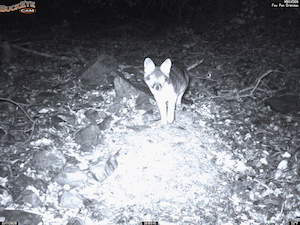

In [26]:
from PIL import Image

file_name = "../../img/sample-img-fox.jpg"

with open(file_name, 'rb') as f:
    payload = f.read()

Image.open(file_name)

In [52]:
%%time
client = boto3.client("runtime.sagemaker")
response = client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/x-image", Body=payload
)
response = json.loads(response["Body"].read())

NameError: name 'json' is not defined

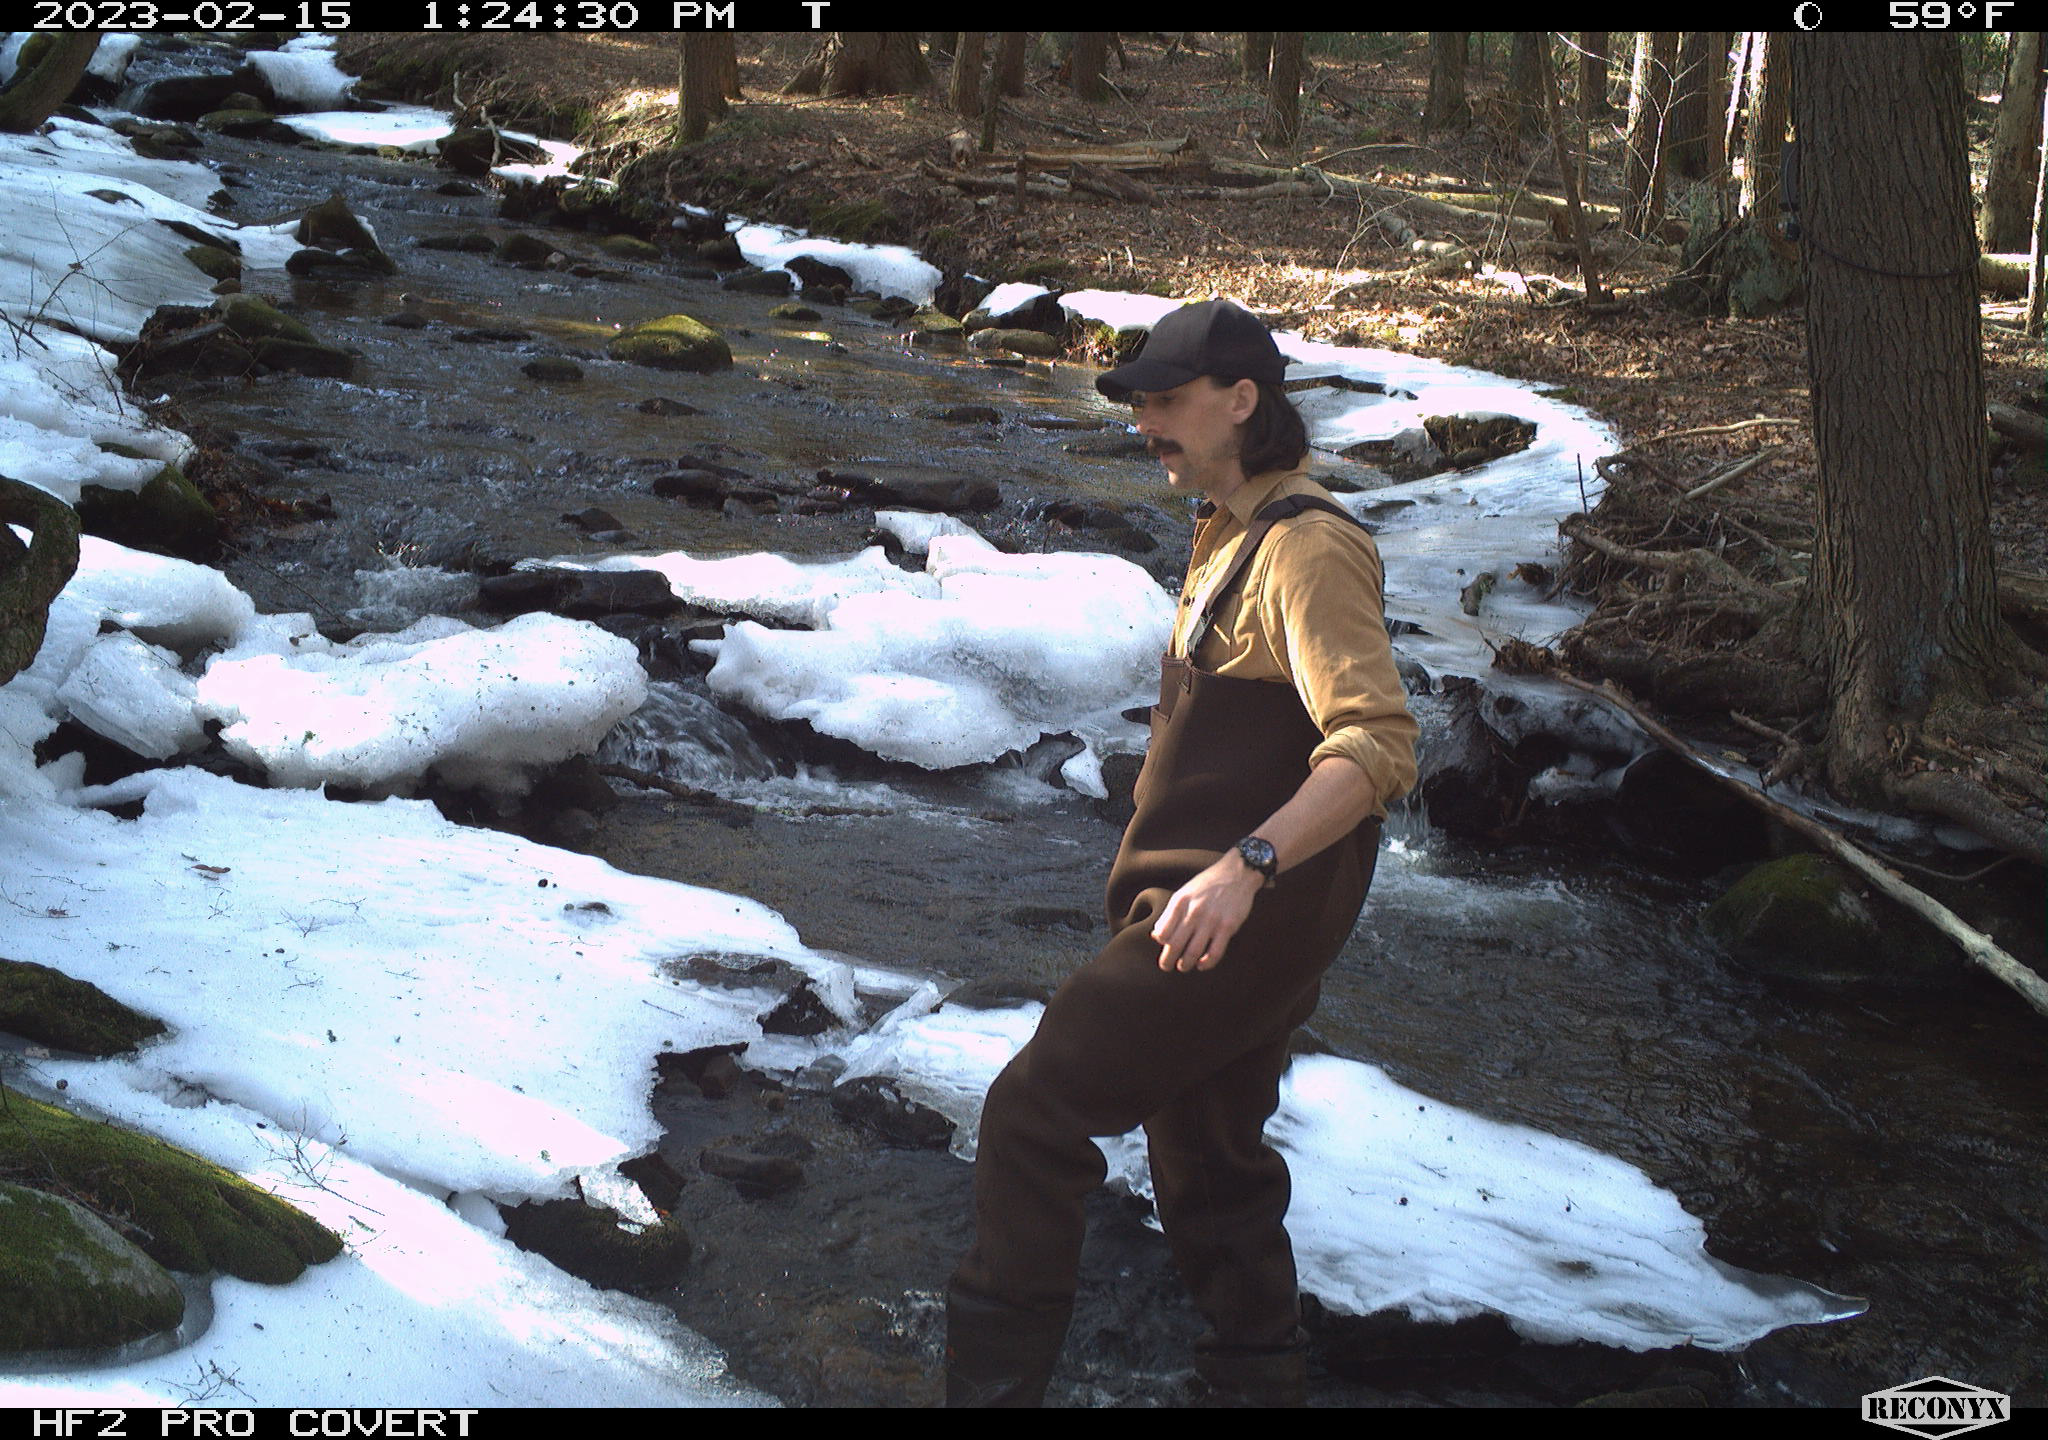

In [75]:
file_name = "/Users/jeff/data/fpe/pii/atherton-20230215/Images/Atherton Brook__2023-02-15__13-24-30(2).JPG"

with open(file_name, 'rb') as f:
    payload = f.read()

Image.open(file_name)

In [77]:
%%time
client = boto3.client("runtime.sagemaker")
response = client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/x-image", Body=payload
)
response = json.loads(response["Body"].read())
response

CPU times: user 12.7 ms, sys: 2.66 ms, total: 15.3 ms
Wall time: 2.52 s


[{'x1': 0.458132266998291,
  'y1': 0.20579323172569275,
  'x2': 0.6950961947441101,
  'y2': 0.9773133993148804,
  'confidence': 0.9594815969467163,
  'class': 2},
 {'x1': 0.38174667954444885,
  'y1': 0.17753461003303528,
  'x2': 0.41856175661087036,
  'y2': 0.209136962890625,
  'confidence': 0.0020152078941464424,
  'class': 1},
 {'x1': -0.00011390596773708239,
  'y1': 0.3097953498363495,
  'x2': 0.041148580610752106,
  'y2': 0.5668178796768188,
  'confidence': 0.0011660860618576407,
  'class': 1}]

## Clean Up

In [91]:
# sm.delete_model(ModelName=sm_model_name)
sm.delete_endpoint(EndpointName=endpoint_name)
sm.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

{'ResponseMetadata': {'RequestId': 'e8874702-c1bf-495c-b3b4-c1b5a1d2d770',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e8874702-c1bf-495c-b3b4-c1b5a1d2d770',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 23 Feb 2023 02:07:13 GMT'},
  'RetryAttempts': 0}}

# Batch Transform

In [99]:
batch_input = f"s3://{s3_bucket_name}/{s3_prefix}/data/atherton/"
batch_output = f"s3://{s3_bucket_name}/{s3_prefix}/out/atherton/"
batch_input

's3://sagemaker-us-east-1-474916309046/fpe-pii-detector/data/atherton/'

In [101]:
!aws s3 ls {batch_input}

2023-02-22 21:14:44          0 
2023-02-22 21:16:29     508457 Atherton Brook__2023-02-15__13-01-00(1).JPG
2023-02-22 21:16:29     526755 Atherton Brook__2023-02-15__13-01-30(2).JPG
2023-02-22 21:16:29     531380 Atherton Brook__2023-02-15__13-02-00(1).JPG
2023-02-22 21:16:29     523418 Atherton Brook__2023-02-15__13-05-00(1).JPG
2023-02-22 21:16:29     535428 Atherton Brook__2023-02-15__13-05-30(2).JPG
2023-02-22 21:16:29     535632 Atherton Brook__2023-02-15__13-06-30(2).JPG
2023-02-22 21:16:29     548020 Atherton Brook__2023-02-15__13-07-00(1).JPG
2023-02-22 21:16:29     528977 Atherton Brook__2023-02-15__13-07-30(2).JPG
2023-02-22 21:16:29     519673 Atherton Brook__2023-02-15__13-08-00(1).JPG
2023-02-22 21:16:29     522770 Atherton Brook__2023-02-15__13-08-30(2).JPG
2023-02-22 21:16:29     520087 Atherton Brook__2023-02-15__13-09-00(1).JPG
2023-02-22 21:16:30     524933 Atherton Brook__2023-02-15__13-09-30(2).JPG
2023-02-22 21:16:30     516498 Atherton Brook__2023-02-15__13-10-00(

In [105]:
import time

batch_job_name = 'fpe-pii-mdv5-batch' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
batch_job_name

'fpe-pii-mdv5-batch2023-02-23-02-19-47'

In [108]:
request = {
    "ModelClientConfig": {
        "InvocationsTimeoutInSeconds": 3600,
        "InvocationsMaxRetries": 1,
    },
    "TransformJobName": batch_job_name,
    "ModelName": sm_model_name,
    "BatchStrategy": "MultiRecord",
    "TransformOutput": {"S3OutputPath": batch_output, "AssembleWith": "Line"},
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": batch_input}
        },
        "CompressionType": "None",
    },
    "TransformResources": {"InstanceType": "ml.m5.large", "InstanceCount": 1},
}

In [109]:
%%time
sm.create_transform_job(**request)

while True:
    response = sm.describe_transform_job(TransformJobName=batch_job_name)
    status = response["TransformJobStatus"]
    if status == "Completed":
        print("Transform job ended with status: " + status)
        break
    if status == "Failed":
        message = response["FailureReason"]
        print("Transform failed with the following error: {}".format(message))
        raise Exception("Transform job failed")
    print("Transform job is still in status: " + status)
    time.sleep(30)

Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job ended with status: Completed
CPU times: user 332 ms, sys: 59.1 ms, total: 391 ms
Wall time: 7min 4s


Using a manifest file

In [114]:
import os
files = os.listdir("/Users/jeff/data/fpe/pii/atherton-20230215/Images/")
# insert dict at start of files array
files.insert(0, {"prefix": f"s3://{s3_bucket_name}/{s3_prefix}/data/atherton/"})
# save files array to json
with open("atherton.manifest", "w") as f:
    json.dump(files, f)

!aws s3 cp atherton.manifest s3://{s3_bucket_name}/{s3_prefix}/data/

upload: ./atherton.manifest to s3://sagemaker-us-east-1-474916309046/fpe-pii-detector/data/atherton.manifest


In [129]:
batch_job_name = 'fpe-pii-mdv5-batch-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
batch_input = f"s3://{s3_bucket_name}/{s3_prefix}/data/atherton/"
batch_output = f"s3://{s3_bucket_name}/{s3_prefix}/out/{batch_job_name}/"
request = {
    "ModelClientConfig": {
        "InvocationsTimeoutInSeconds": 3600,
        "InvocationsMaxRetries": 1,
    },
    "TransformJobName": batch_job_name,
    "ModelName": sm_model_name,
    "BatchStrategy": "MultiRecord",
    # "MaxConcurrentTransforms": 8, # max no. cpus
    "TransformOutput": {"S3OutputPath": batch_output, "AssembleWith": "Line"},
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": batch_input}
        },
        "CompressionType": "None",
    },
    "TransformResources": {"InstanceType": "ml.m5.large", "InstanceCount": 8},
}

In [130]:
%%time
sm.create_transform_job(**request)

while True:
    response = sm.describe_transform_job(TransformJobName=batch_job_name)
    status = response["TransformJobStatus"]
    if status == "Completed":
        print("Transform job ended with status: " + status)
        break
    if status == "Failed":
        message = response["FailureReason"]
        print("Transform failed with the following error: {}".format(message))
        raise Exception("Transform job failed")
    print("Transform job is still in status: " + status)
    time.sleep(30)

Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job ended with status: Completed
CPU times: user 279 ms, sys: 43.5 ms, total: 323 ms
Wall time: 6min 33s
